In [177]:
import csv
import requests
import pandas as pd
import json
from datetime import datetime

csv_filename = './us_state_vaccinations.csv'

url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv'


In [193]:
json_template = {
  "type": "line",
  "data": {
      "labels": ["Red", "Blue", "Yellow", "Green", "Purple", "Orange"],
      "datasets": [{
          "label": "Percentage of People currently vaccinated",
          "data": [12, 19, 3, 5, 2, 3],
          "backgroundColor": [
              "rgba(255, 99, 132, 0.2)",
          ],
          "borderColor": "rgba(255, 99, 132, 0.7)",

          "borderWidth": 3
      },{
          "label": "Prediction",
          "data": [12, 19, 3, 5, 2, 3],
          "backgroundColor": [
              "rgba(64, 128, 0, 0.2)",
          ],
          "borderColor": "rgba(64, 128, 0, 0.7)",

          "borderWidth": 1,
          "pointRadius" : 3,
          "pointStyle" : "dash",
          "showLine": True
      },
          {
          "label": "Herd immunity Level",
          "data": [12, 19, 3, 5, 2, 3],
          "backgroundColor": [
                     "rgba(0, 230, 230, 0.2)"
                ],
            "borderColor":  "rgba(0, 230, 230, 0.7)",
            "borderWidth": 2,
            "showLine": False,
            "pointRadius" : 2,
            "pointStyle" : "dash"
      }
      ]
  },
  "options": {
      
      "scales": {
          "x": {
              "type": "timeseries"
          },
          "yAxes": [{
              "ticks": {
                  "beginAtZero": True
              }
          }]
      }
  }
}

In [194]:
# Get CSV Data
response = requests.get(url)

if response.status_code == 200:
    with open(csv_filename, 'wb') as file:
        for chunk in response:
            file.write(chunk)
            

# Convert to DataFrame
df = pd.read_csv('./us_state_vaccinations.csv')

# Get States List as JSON
states_list = list(set(df[df['location'].notna()]['location'].tolist()))

with open('states_list.json', 'w') as state_list_file:
    state_list_file.write(json.dumps(states_list, indent=4))
    

# Get state-wise stats as JSONs
grouped_by_state = df.groupby('location')



In [212]:
def get_forecast_df(state_df):
    state_df = state_df[state_df['people_fully_vaccinated_per_hundred'].notna()]
    state_df=state_df[['date', 'people_fully_vaccinated_per_hundred']]
    past_dates_len=state_df.shape[0]
    state_df.columns=['ds','y']

    #predict
    m = Prophet()   
    m.fit(state_df)
    future = m.make_future_dataframe(periods=250)
    forecast = m.predict(future)


    #data formatting
    forecast.rename(columns = {"ds": "date", "yhat": "prediction"}, inplace = True)
    is_past = pd.Series([True]*past_dates_len + [False]*(forecast.shape[0]-past_dates_len))

    forecast["is_past"]=is_past
    forecast = forecast[["date", "prediction","is_past"]]
    forecast['past_series'] = forecast.apply (lambda row: row['prediction'] if row['is_past'] else "null", axis=1)
    forecast['future_series'] = forecast.apply (lambda row: row['prediction'] if not row['is_past'] else "null", axis=1)
    
    forecast['herd_series']=pd.Series([65]*forecast.shape[0])
    
    forecast=forecast[forecast['prediction']<=100]
    
    return forecast


def get_herd_immunity_date(forecast):
    for ind,row in forecast.iterrows():
    #     if row['people_fully_vaccinated_per_hundred']>=65:
        if(row['future_series']!='null'):
            if(int(row['future_series']))>=65:
                return row['date']

In [213]:
f=get_herd_immunity_date(forecast)

'2021-08-28'

In [196]:


for state in grouped_by_state['location']:
    state = state[0]
    state_df = grouped_by_state.get_group(state)
    
    
    forecast=get_forecast_df(state_df)
    

    state_json = json_template
    
 

    state_json['data']['labels'] = [datetime.strptime(str(s), '%Y-%m-%d').strftime('%b %d') for s in forecast.date.dt.strftime('%Y-%m-%d').tolist()]
    
    state_json['data']['datasets'][0]['data'] = forecast['past_series'].tolist()

    state_json['data']['datasets'][1]['data'] = forecast['future_series'].tolist()
    
    state_json['data']['datasets'][2]['data'] = forecast['herd_series'].tolist()
    
    
    with open(state + '.json', 'w') as state_json_file:
        state_json_file.write(json.dumps(state_json, indent=4))
    
    print(state)
    break


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Alabama


In [33]:
state_df=state_df[['date', 'people_fully_vaccinated_per_hundred']]
state_df.columns=['ds','y']

In [99]:
x=[1,2]
y=[3,4]
x.extend(y)
x

[1, 2, 3, 4]

In [61]:
state_df

,ds,y
6935,2021-01-12,0.37
6936,2021-01-13,0.44
6938,2021-01-15,0.48
6942,2021-01-19,0.56
6943,2021-01-20,0.59
...,...,...
7038,2021-04-25,26.01
7039,2021-04-26,26.86
7040,2021-04-27,26.87
7041,2021-04-28,26.90


In [72]:
# Python
import pandas as pd
from fbprophet import Prophet

In [73]:
m = Prophet()   
m.fit(state_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
future = m.make_future_dataframe(periods=100)

In [78]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
198,2021-08-03,58.426287,52.523638,64.222168
199,2021-08-04,58.608521,52.523324,64.466673
200,2021-08-05,58.867825,52.790198,64.898517
201,2021-08-06,59.365114,53.029178,65.637362
202,2021-08-07,59.620727,53.220772,65.855920


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


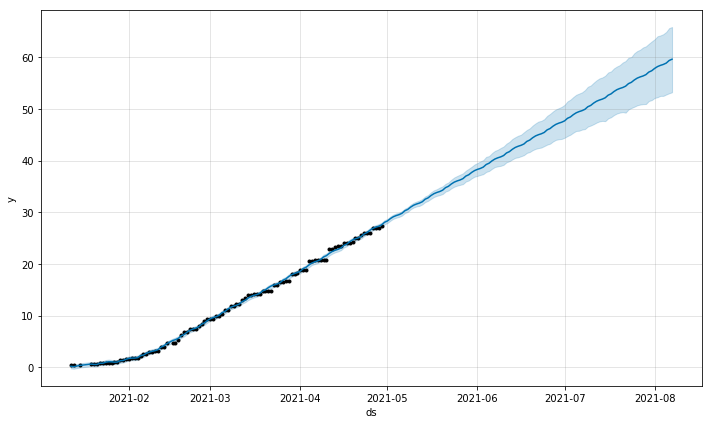

In [79]:
fig1 = m.plot(forecast)

In [82]:
forecast.tail()

,date,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
198,2021-08-03,58.382703,52.523638,64.222168,52.371087,64.276082,0.043583,0.043583,0.043583,0.043583,0.043583,0.043583,0.0,0.0,0.0,58.426287
199,2021-08-04,58.702178,52.523324,64.466673,52.552991,64.696834,-0.093657,-0.093657,-0.093657,-0.093657,-0.093657,-0.093657,0.0,0.0,0.0,58.608521
200,2021-08-05,59.021653,52.790198,64.898517,52.733210,65.162435,-0.153828,-0.153828,-0.153828,-0.153828,-0.153828,-0.153828,0.0,0.0,0.0,58.867825
201,2021-08-06,59.341128,53.029178,65.637362,52.923870,65.573754,0.023986,0.023986,0.023986,0.023986,0.023986,0.023986,0.0,0.0,0.0,59.365114
202,2021-08-07,59.660602,53.220772,65.855920,53.175833,65.985456,-0.039875,-0.039875,-0.039875,-0.039875,-0.039875,-0.039875,0.0,0.0,0.0,59.620727


In [83]:
forecast.rename(columns = {"ds": "date", "yhat": "prediction"}, 
          inplace = True)

In [84]:
forecast.head()

,date,prediction,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-12,0.141568,-0.220673,0.605050,0.141568,0.141568,0.043583,0.043583,0.043583,0.043583,0.043583,0.043583,0.0,0.0,0.0,0.185152
1,2021-01-13,0.203472,-0.280574,0.496241,0.203472,0.203472,-0.093657,-0.093657,-0.093657,-0.093657,-0.093657,-0.093657,0.0,0.0,0.0,0.109815
2,2021-01-15,0.327280,-0.055553,0.758097,0.327280,0.327280,0.023986,0.023986,0.023986,0.023986,0.023986,0.023986,0.0,0.0,0.0,0.351267
3,2021-01-19,0.574897,0.204755,1.005529,0.574897,0.574897,0.043583,0.043583,0.043583,0.043583,0.043583,0.043583,0.0,0.0,0.0,0.618480
4,2021-01-20,0.636801,0.141379,0.951599,0.636801,0.636801,-0.093657,-0.093657,-0.093657,-0.093657,-0.093657,-0.093657,0.0,0.0,0.0,0.543144


In [86]:
state_df

,ds,y
6935,2021-01-12,0.37
6936,2021-01-13,0.44
6938,2021-01-15,0.48
6942,2021-01-19,0.56
6943,2021-01-20,0.59
...,...,...
7038,2021-04-25,26.01
7039,2021-04-26,26.86
7040,2021-04-27,26.87
7041,2021-04-28,26.90
